#### Importing the train.csv file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [2]:

pd.set_option("display.max_colwidth", 200)

In [3]:
train_data = pd.read_csv('Data/train.csv', encoding='latin1')

In [4]:
train_data.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Kmï¿½),Density (P/Kmï¿½)
0,cb774db0d1,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,noon,60-70,Angola,32866272,1246700.0,26


In [5]:
train_data.drop(['textID', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Kmï¿½)', 'Density (P/Kmï¿½)'], axis=1, inplace=True)
train_data['sentiment'] = train_data['sentiment'].replace({'positive': 1, 'negative': 2, 'neutral': 0})

In [6]:
train_data.head()

,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,2
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on the releases we already bought",2


#### Working with Label

In [7]:
train_data['sentiment'].value_counts()

sentiment
0    11118
1     8582
2     7781
Name: count, dtype: int64

<Axes: xlabel='sentiment'>

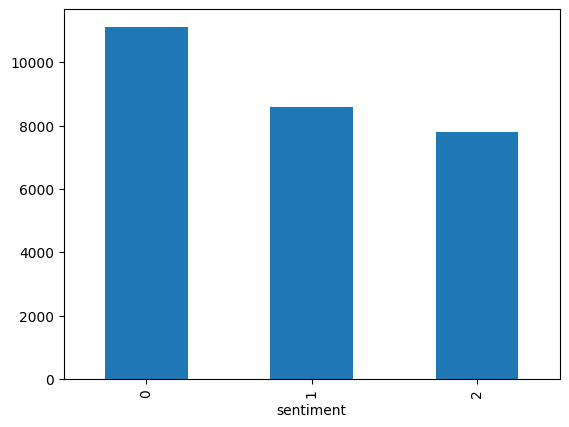

In [8]:
train_data['sentiment'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'label distribution')

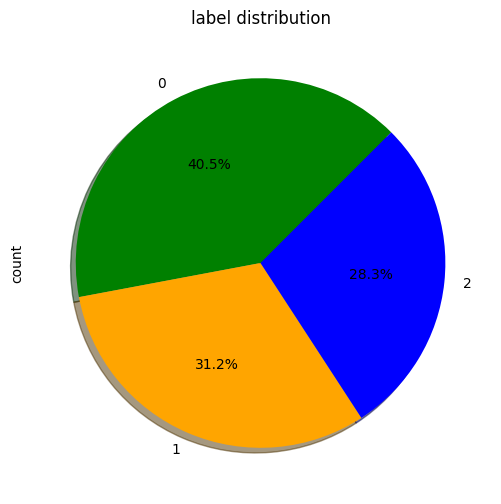

In [9]:
plt.figure(figsize=(10,6))
colors = ['green', 'orange', 'blue']
train_data['sentiment'].value_counts().plot(kind='pie', autopct='%.1f%%', shadow=True, colors = colors, startangle=45)
plt.title('label distribution')

#### Cleaning the Text

In [10]:
# Combining nltk stopwords and sklearn stopwrods. 
# nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords.remove('not')

import sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = set(ENGLISH_STOP_WORDS)

# joining both the stopwords 
all_stopwords = nltk_stopwords.union(sklearn_stopwords)

all_stopwords_list = list(all_stopwords)

print(len(all_stopwords_list))

378


In [11]:
train_data['text'][27477]

' I`ve wondered about rake to.  The client has made it clear .NET only, don`t force devs to learn a new lang  #agile #ccnet'

In [12]:
emoji_pattern = re.compile('(?::|;|=)(?:-)?(?:\)|\(|D|P)')
# nltk.download('punkt')
# nltk.download('wordnet')
def cleaning_the_data(text):
    if not isinstance(text, str):
        text = str(text)
        
    new_text = re.sub(r"'s\b'",' is', text)
    new_text = re.sub(r"#", " ", new_text)
    new_text = re.sub(r"@[A-Za-z0-9]+", " ", new_text)
    new_text = re.sub(r"http\s+", " ", new_text)
    new_text = contractions.fix(new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = re.sub(emoji_pattern, '', new_text)
    new_text = new_text.lower().strip()
    return new_text

def normalize_text(text):
    cleaned_text = cleaning_the_data(text)
    # Tokenize the text
    tokens = word_tokenize(cleaned_text)
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens if len(word) > 2]
    
    # Join tokens back into a single string
    normalized_text = ' '.join(lemmatized_tokens)
    return normalized_text

train_data['normalized_text'] = train_data['text'].apply(normalize_text)

In [13]:
train_data['normalized_text'][27477]

'wondered about rake the client has made clear net only don force devs learn new lang agile ccnet'

### Bag of words model (Feature Extraction)
    1. Countvectorizer
    2. TF-IDF Vectorizer

In [16]:
train_data.shape

(27481, 3)

### Model building

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=None, use_idf=True, norm='l2', smooth_idf=True)
y = train_data['sentiment'].values
x = tfidf.fit_transform(train_data['normalized_text'])
X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.4,shuffle=False)

In [19]:
clf = LogisticRegressionCV(cv=6, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=500).fit(x, y)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.0min finished


Accuracy: 0.8802874556535978


### TF-IDF Vector BoW Model

##### doc1 = 'I love cooking'
##### doc2 = 'Today I cooked pasta today'

##### TF_score = how many times a word (from the vocab) is appearing in a given doc / total no. of words in that doc 
##### TF(today | doc2) = 2/5
##### TF_score will be high for "very frequent" words in a given doc
##### IDF_score = log( (1 + Total no. of documents) / (1 + No. of documents containing that "term"))
##### IDF_score penalizes those words which are EQUALLY frequent in almost all the documents

In [20]:
# import pickle

# # Saving the model
# filename = 'clf.pkl'
# pickle.dump(clf, open(filename, 'wb'))

# # Saving the vectorizer
# filename = 'tfidf.pkl'
# pickle.dump(tfidf, open(filename, 'wb'))

# train_data.to_pickle('train_data.pkl')

#### Prediction

In [21]:
def prediction(comment):
    preprocess_comment = normalize_text(comment)
    comment_list = [preprocess_comment]
    comment_vector = tfidf.transform(comment_list)
    prediction = clf.predict(comment_vector)
    if prediction == 0:
        return 'Neutral'
    elif prediction == 1:
        return 'Positive'
    else:
        return 'Negative'
    
comment = "I Love ittt"
print(prediction(comment))

Positive
